In [61]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from smart_simulation.cfg_templates.config import package_dir
from smart_simulation.outputs import output_utils as ou
from smart_simulation.ds_tools import data_eng as de
from smart_simulation.ds_tools import eda
from smart_simulation.ds_tools import sarima_forecast as sf
from sklearn.model_selection import TimeSeriesSplit
# from smart_simulation.ds_tools import sma_forecast as sma
# from smart_simulation.ds_tools import analyze_forecast as af

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
weights_file_list = ou.weight_files()
servings_file_list = ou.servings_files()

# EDA
## Quick Visualization and data clean up
### Raw Weight Visualization

In [140]:
sample = de.load_sim_data(weights_file_list[-1], ['weight'])
eod_weights = de.eod_weights(sample.weight)
eod_weight_peaks = eda.find_weight_peaks(weight_series = eod_weights)

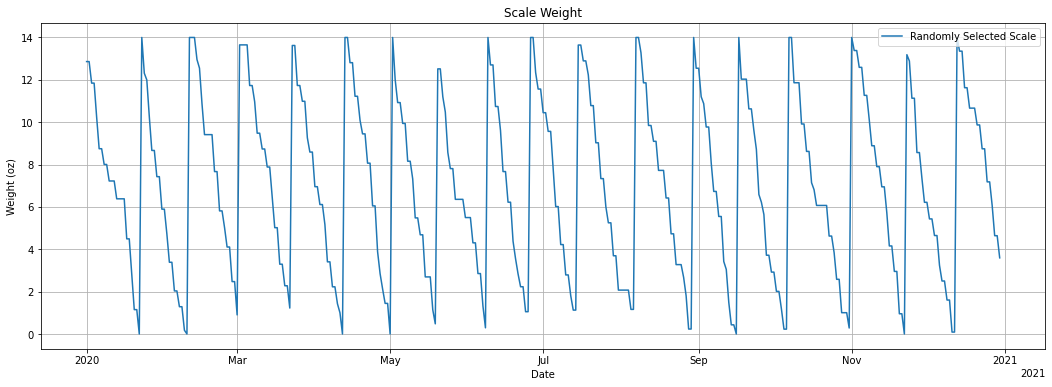

In [141]:
eda.plot_weights(eod_weights, 'Scale Weight', 'Randomly Selected Scale', bar = False)

### Consumption Visualization
#### Raw Consumption Calculation

In [142]:
raw_consumption = de.calculate_consumption(weight_series = eod_weights, adjustments = None)

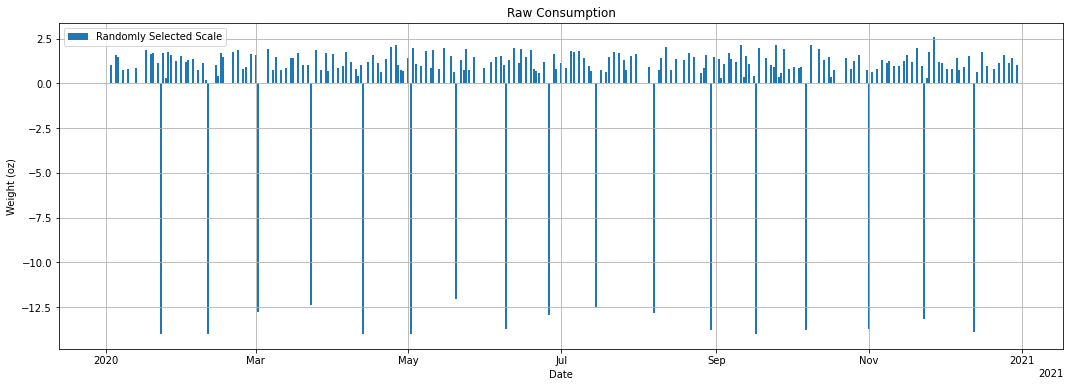

In [143]:
eda.plot_weights(raw_consumption, 'Raw Consumption', 'Randomly Selected Scale', bar = True)

#### Find Product Arrival Dates to Fix Consumption Outliers

In [149]:
estimated_peaks = eda.find_weight_peaks(weight_series = eod_weights)
segments = eda.create_consumption_segments(weight_series = eod_weights, peaks = estimated_peaks)
segments_data = eda.create_segments_data(consumption_segments = segments, weight_series = eod_weights)
segments_misaligned = eda.segments_misaligned(segments_data = segments_data)

print(f"\nBreak Point Segments Misaligned: {segments_misaligned}\n")
segments_data


Break Point Segments Misaligned: False



,time_delta,start_time,max_weight_time,end_time,min_weight_time,start_weight,max_weight,end_weight,min_weight
0,21 days,2020-01-01,2020-01-01,2020-01-22,2020-01-22,12.861788,12.861788,0.000000,0.000000
1,18 days,2020-01-23,2020-01-23,2020-02-10,2020-02-10,14.000000,14.000000,0.000000,0.000000
2,19 days,2020-02-11,2020-02-11,2020-03-01,2020-03-01,14.000000,14.000000,0.900817,0.900817
3,20 days,2020-03-02,2020-03-02,2020-03-22,2020-03-22,13.649749,13.649749,1.223625,1.223625
4,20 days,2020-03-23,2020-03-23,2020-04-12,2020-04-12,13.621779,13.621779,0.000000,0.000000
5,18 days,2020-04-13,2020-04-13,2020-05-01,2020-05-01,14.000000,14.000000,0.000000,0.000000
6,17 days,2020-05-02,2020-05-02,2020-05-19,2020-05-19,14.000000,14.000000,0.478759,0.478759
7,19 days,2020-05-20,2020-05-20,2020-06-08,2020-06-08,12.516940,12.516940,0.290924,0.290924
8,16 days,2020-06-09,2020-06-09,2020-06-25,2020-06-25,14.000000,14.000000,1.051156,1.051156
9,18 days,2020-06-26,2020-06-26,2020-07-14,2020-07-14,14.000000,14.000000,1.126692,1.126692


In [150]:
estimated_peaks

[Timestamp('2020-01-23 00:00:00'),
 Timestamp('2020-02-11 00:00:00'),
 Timestamp('2020-03-02 00:00:00'),
 Timestamp('2020-03-23 00:00:00'),
 Timestamp('2020-04-13 00:00:00'),
 Timestamp('2020-05-02 00:00:00'),
 Timestamp('2020-05-20 00:00:00'),
 Timestamp('2020-06-09 00:00:00'),
 Timestamp('2020-06-26 00:00:00'),
 Timestamp('2020-07-15 00:00:00'),
 Timestamp('2020-08-07 00:00:00'),
 Timestamp('2020-08-30 00:00:00'),
 Timestamp('2020-09-17 00:00:00'),
 Timestamp('2020-10-07 00:00:00'),
 Timestamp('2020-11-01 00:00:00'),
 Timestamp('2020-11-23 00:00:00'),
 Timestamp('2020-12-13 00:00:00')]

#### Clean up consumption calculations

In [151]:
arrival_time_stamps = estimated_peaks # segments_data.start_time[1:]
index = pd.DatetimeIndex(arrival_time_stamps).rename(None)
adjustments = pd.Series(14.0, index = index, dtype = float, name = 'weight')

In [158]:
daily_consumption = de.calculate_consumption(weight_series = eod_weights, adjustments = adjustments)

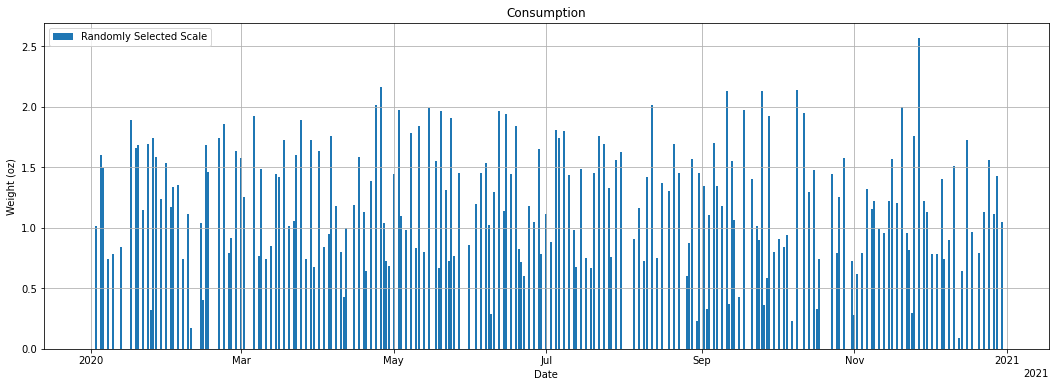

In [159]:
eda.plot_weights(daily_consumption, 'Consumption', 'Randomly Selected Scale', bar = True)

# Modeling Approach
## What are we trying to answer?
An end to end smart subscription contains multiple components. Right now were are just considering the ordering process.
**When should a new order be triggered for customer (X) for just-in-time delivery of product (a)?**

### Question subcomponents
1. Shipping duration estimate
- How long will shipping take for product (a) to reach customer (X)?
2. Remaining life of customer's current stock estimate
- How many days of consumption of product (a) does customer (X) have left in current stock?

Currently we're trying to answer question (2).


### Brief review of a few constraints
1. The weight/stock is directly influenced by the customer's consumption
2. As long as there is product available, we can assume future consumption on a long enough timeline
3. Scale weight measurement error does occur
4. New bags come in a variety of weights (12oz, 32oz, etc.)
5. Scale weight should fall within an expected range  
    - minimum = 0  
    - maximum = weight of last bag shipped to customer + prexisting measurement at last bag arrival  

### Forecasting options
We have two general paths we can take to answer our question: How many days of consumption of product (a) does customer (X) have left in current stock?
1. Forecast expected number of days left using historic weight
    - forecast future weight using historic weight
    - set a threshold, likely 0 or some number representing '1 day of consumption left' 
    - find the timestamp where the forecast crosses the threshold
2. Forecast expected number of days left using historic consumption
    - calculate consumption from historic weight  
    - forecast consumption  
    - set a threshold, likely 0 or some number representing '1 day of consumption left'  
    - find the timestamp where the forecast crosses the threshold  

For the sake of simplicity we might think option (1) would be better, because we have one less step listed. However, asssume there are subcomponents to each step. We also haven't given the problem constraints much consideration.

#### Detailed assessment of options
1. Forecasts should assume no replenishment within forecast period. Put another way, we need to assume a contantly diminishing stock.
    - **Weight based forecast**
        - weight series requires correction
            - could calculate an **infinite** weight series, essentially a backwards cumulative weight
    - **Consumption based forecast**
        - Earlier in the EDA portion we already saw how we can correct consumption on replenishment days
2. Expect some missing or bad data in weight measurements
    - **Weight based forecast**
        - Difficult to correct, because weight at timestamp t is dependent on weight at t-1
        - Possible solution would use a pseudo or expected consumption
            - solution space traveling: weight -> consumption - weight
            - non-optimal path
    - **Consumption based forecast**
        - We have historic values we can use to create a correction method
            - consumption at timestamp t is, for the most part, independent on consumption at t-1 
                - consumer might self-ration, but unlikely, or infrequent
                - consumption at time t-1 might indicate availability of consumer (in town/out of town) but that is not true dependence
3. There will be days where no product is available for consumption (AKA stock is empty)
    - **Weight based forecast**
        - Weight values for days with no available product for consumption will innaccurately describe consumer behavior
        - This would be difficult to continually correct for the same reason in # 3
    - **Consumption based forecast**
        - Again, we have historic values we can use to create a correction method        

All that to say **consumption is a simplified solution allows for more flexibilty when we come across problems with modeling**.

Lets now reframe our question:
**Given the current weight and historic consumption, how many remaining days of available consumption remain?**

## Statistical Forecasting

I will not be going into a full explination of statistical time series forecasting here. If you're curious to learn more, feel free to checkout my growing [repository of resources and notes](https://github.com/jbpauly/notes/tree/master/content/time_series). Immediate resource recommendations:
1. [Forecasting: Principle and Practice](https://otexts.com/fpp2/#)
2. [Applied Time Series Analysis (PennState STAT 510)](https://online.stat.psu.edu/stat510/)
3. [Statsmodel Python Package](https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_sarimax_stata.html)

It is important to review a bit from a high level. The following comes from my notes of various courses and resources.

### Requirements
Stationary data is required for use of statistical methods. Some modeling approaches can account for non-stationarity, which we'll use for our final model. 
#### Elements of Stationarity:
1. Constant Mean
    - Value is not drifting over time
2. Constant Variance
    - Unpredictability is not changing over time
3. Constant Autocorrelation
    - Structure is not changing over time 

##### Checking for stationarity
1. Visalize raw dataset
    - Observable trending, seasonality, cyclicality?
2. Visualize rolling mean and standard deviation
3. Augmented Dickey Fuller (ADF) test
    - Statistical significance test 
        - null hypothesis assumes presence of unit root
    - Categorized as a 'Unit Root Test'
        - Any presence of a unit root means non-stationarity
4. Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test
    - Statistical significance test 
        - null hypothesis assumes **NO** presence of unit root
    - Categorized as a 'Unit Root Test'
        - Any presence of a unit root means non-stationarity
    - Different from ADF, because it can test for stationarity through 'deterministic trend'
    
In the real world, we rarely find stationary data, so we have to correct for it. Most commonly, seasonality and trending cause non-stationarity.

#### Transformations: non-stationary -> stationary
1. Remove trending
    - difference or log difference of values
    - subtract a moving average from values
    - take a linear regression of values
2. Remove seasonality
    - average around seasons
    - use **locally weighted scatterplot smoothing (loess)**
3. Remove increasing variance
    - power transformation
    - log transformation
    
Other high points to not regarding transformations for stationarity:
- Try and use transformations that are 1 to 1
    - That way it's easy to get back to original solution space
    - It is okay to have multiple transforms if you can keep track of it, AND it is necessary
- Don't try and remove autocorrelation
    - Generally tough to do and probably means there's an underlying aspect of the problem we're not considering (should I break this up into different time datasets)

### Modeling
Similar to machine learning, models can be combined in statistical time series analysis and forecasting. Well be using the SARIMAX family of models. SARIMAX is short for **Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model**. Quite a mouthful, but not so complicated when broken down.


SARIMAX is a combination for 5 components:
1. **S**easonal
2. **A**uto**R**egressive
3. **I**ntegrated
4. **M**oving**A**verage
5. e**X**ogenous regressors

The foundation and most basical models from SARIMAX are AR, MA, and their combination, ARMA.

#### Autoregressive (AR(p))
> X_t = φ_1*X_t-1 +…+ φ_pX_t-p + ε_t
- Stationary process if abs(φ) < 1
- Essentially AR says your present value has something to do with your past value
- p term: order of AR (lags)
- Use PACF plot to find p
- **Requires stationary data**

#### Moving Average (MA(q))
> X_t = μ + ε_t + θ_1ε_t-1 +…+ θ_qε_t-q 
- Stationary process regardless of values of θ
- Essentially MA says you oscolate around a mean, μ, with some error
- q term: order of MA (lags)
- Use ACF plot to find q
- **Requires stationary data**

#### Autoregressive Moving Average (ARMA(p,q))
Combination of AR+MA
- Use if exploratory data analysis shows significance in lag factors for both AR and MA models
- **Requires stationary data**

#### Autoregressive Integrated Moving Average (ARIMA(p,d,q))
ARMA plus an **I**ntegrated term, (d)
- d term: order of differencing (typically 0, 1, 2)
    - removes trending, but you need to know your data and specify the degree of differencing
- **Can handle trending but not seasonality**
    - requires understanding of the data

#### Seasonal Autoregressive Integrated Moving Average (SARIMA(p,d,q)(P,D,Q)m)
ARIMA model plus 4 additional seasonal terms, (P,D,Q,m)
- P, D, Q terms: same as p, d, q, but for the **seasonal** aspect of the model 
- m term: number of data samples or time steps in each 'season'
- **Can handle trending and seasonality**
    - requires understanding of the data
    
##### Further explination of SARIMA
Take a dataset with daily frequency and observed weekly seasonality.
- m = 7 | 7 samples (days) per season (week)
- non-seasonal ARIMA
    - p,d,q are all in relation to the raw frequency
        - "How is Friday related to Thursday? To Wednesday?"
        - Think, between the seasons
- seasonal ARIMA
    - P,D,Q are all in relation to the seasonal frequency (m)
        - "How is Monday of week 3 related to Monday of week 2? To Monday of week 1?"
        - Think, from season to season


#### Seasonal Autoregressive Integrated Moving Average with Exogenous regressors (SARIMAX(p,d,q)(P,D,Q,m)(r))
SARIMA model plus additional data parameter(s) for each timestep
- r term: additional regressors

#### Example use of a full SARIMAX model
Forecasting monthly commute time in Minneapolis for 2021 and have historic data from 1990 to 2020.
- **AR**, commute times this month have some relation to commute times last month. It's likely this is a relationship to local population.
- **I**, commute times have increased linearly with population density (trending).
- **MA**, despite relationship month to month in commute time, based on the relationship to population, the number of drivers on the roads ebs and flows around holidays, events, etc. but reverts back to a mean.
- **S**, commute times always increase in the winter due to snow.
- **X**, amount of precipitation factors into commute times on a local level. Commute times increase overall in the winter, but in relation to the amount of snowfall.


### Weight forecasting
We will take a brief look at weight to help describe elements of statistical modeling, even though we don't plan to use it long term.

Ignoring the obvious trending and seasonality, lets just try out a few models to get comfortable with the ARIMA models

1. AR
- Heavily assumes past value at t-1 influences value at t
- Above statement should lead us to think AR would apply well for the raw weight
    - In theory we should always have a negatively trending weight between bag cylces, so weight today, is influenced by weight yesterday
2. MA
- Heavily assumes mean reversion, think if it like values oscolating around the mean at random with some error
- Above statement should lead us to think MA might not apply well for raw weight
    - Short term moving average might be okay, but will really struggle with new shipments
    - Overall trending will be dampened
3. ARIMA
- Combination of AR + MA, with a third factor (I)
- detrend the data in modeling
4. SARIMAX
- ARIMA with seasonal handling

## Forecast: Remaining Days of Available Consumption

### Raw Scale Weight
Lets take a quick look at our raw weight values again.

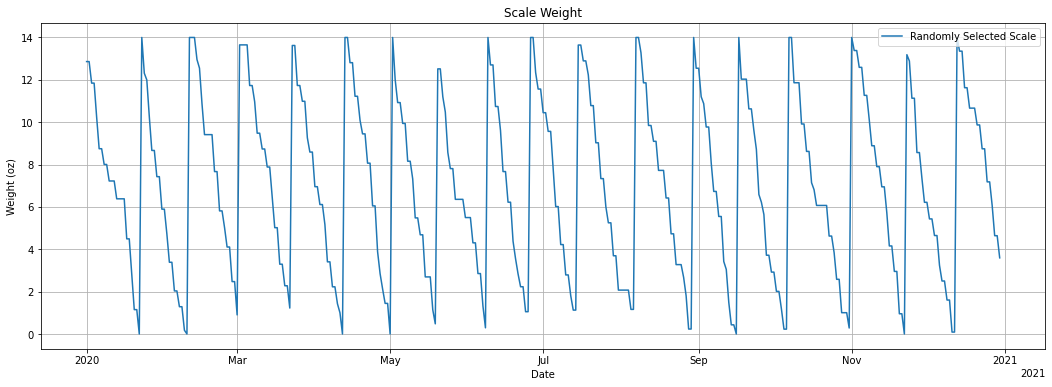

In [160]:
eda.plot_weights(eod_weights, 'Scale Weight', 'Randomly Selected Scale', bar = False)

#### Stationarity Check

From the figure we can observe a few things about the non-stationarity of the data:
1. Clear cyclicality, not seasonality, of the weights between new coffee arrivals 
2. Clear negative trending from full stock to empy stock

From our knowledge the simplified consumer framework used to generate the data, we should also expect weekly seasonality. 

#### Remove Trending
We've already determined we want to forecast consumption, not weight. We also know that differencing values can remove trending, and we calculate consumption by differencing our weight values.

#### Removing cycles
By correcting for new bags arrivals, we also remove the observed cycles.

Lets look at our daily, cleaned consumption.

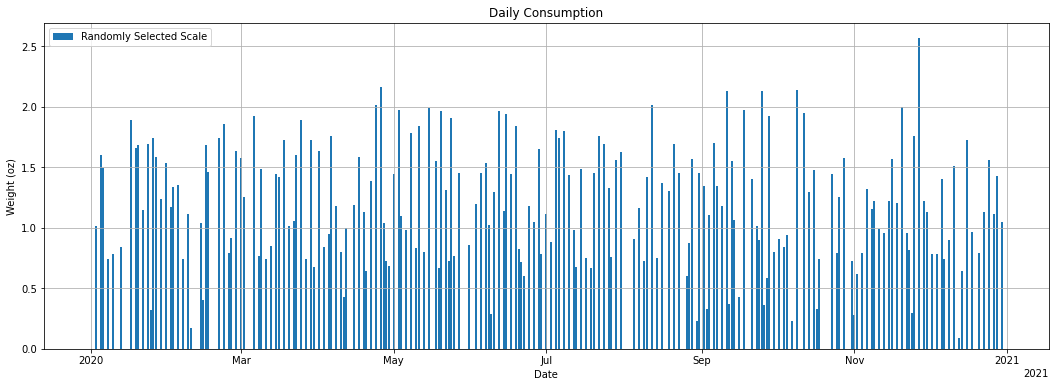

In [161]:
eda.plot_weights(daily_consumption, 'Daily Consumption', 'Randomly Selected Scale', bar = True)

#### Stationarity Check
Visually, it looks like we removed the trending, but we can't precisely say if it's non-stationary at this point.

Lets move onto a seperate section for consumption forecasting before considering to remove any additional non-stationarity.

## Consumption Forecasting

### Seperate into train/test set
Test with the last 14 days of consumption

In [162]:
dc = daily_consumption.copy()
train = dc[:-14]
test = dc[-14:]

#### Stationarity Check
We have surpassed our ability to visually identify non-stationary from raw data values. So lets use other methods.
##### Rules for non-stationarity
1. Constant Mean
2. Constant Variance
3. Constant Autocorrelation

In [163]:
rolling_mean = train.rolling(7).mean()
rolling_std = train.rolling(7).std()

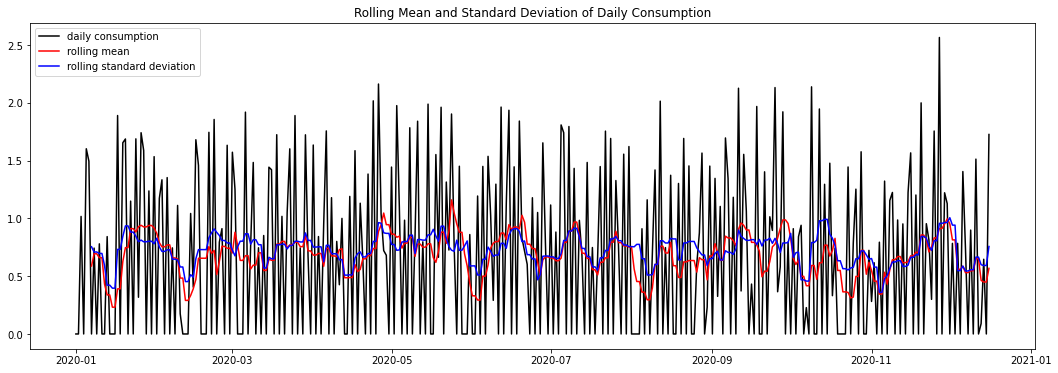

In [164]:
fig = plt.figure(figsize=(18, 6))
raw = plt.plot(train, color = 'black', label ='daily consumption')
mean = plt.plot(rolling_mean, color = 'red', label ='rolling mean')
std = plt.plot(rolling_std, color = 'blue', label ='rolling standard deviation')
plt.title('Rolling Mean and Standard Deviation of Daily Consumption')
plt.legend()
plt.show()

#### Stationarity Check
From our moving average and standard deviation, we likely can't call the cleaned consumption series stationary.

##### AD Fuller Test
Statsmodel adfuller test key elements:
1. The p-value
2. The value of the test statistic
3. Number of lags considered for the test
4. The critical value cutoffs.

In [165]:
from statsmodels.tsa.stattools import adfuller

In [166]:
adf_results = adfuller(train, autolag='AIC')
print(f'ADF Statistic: {adf_results[0]:.2f}')
print(f'p-value: {adf_results[1]:.2f}')
print(f'n_lags: {adf_results[2]:.2f}')
for key, value in adf_results[4].items():
    print('Critial Values:')
    print(f'   {key}, {value:.2f}')

ADF Statistic: -5.24
p-value: 0.00
n_lags: 13.00
Critial Values:
   1%, -3.45
Critial Values:
   5%, -2.87
Critial Values:
   10%, -2.57


##### ADF analysis
The null hypothesis of an ADF test always assume non-stationarity.
- significance value = 0.05
- p-value = 0
- p-value < significance value

Can assume stationarity with the null hypothesis disproved? Maybe.

Let's double check the ACF, PACF, and seasonal decompositon plots.

#### ACF plot
ACF can be used to find the q term for a Moving Average (MA(q)) model.
To select q, we want to find the lag value that drops below the significance interval.

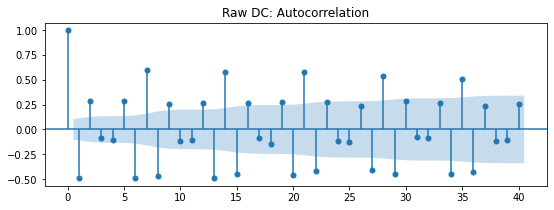

In [167]:
fig = plt.figure(figsize=(9,3))
ax1 = fig.add_subplot(111)
fig = sm.graphics.tsa.plot_acf(train, lags=40, ax = ax1, title='Raw DC: Autocorrelation')
plt.show()

The 3rd lag drops below the significance interval, but there is no clear cutoff for an optimal lag in the ACF plot. **This is a clear sign of underlying seasonality.**

#### PACF plot

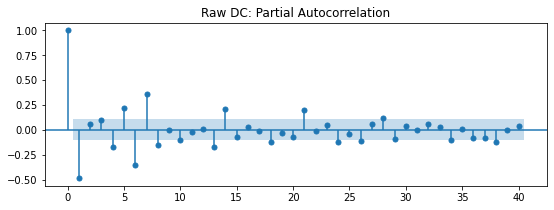

In [168]:
fig = plt.figure(figsize=(9,3))
ax1 = fig.add_subplot(111)
fig = sm.graphics.tsa.plot_pacf(train, lags=40, ax = ax1, title='Raw DC: Partial Autocorrelation')
plt.show()

In the PACF plot we see significance through most lags up until the 7th, and then every 7 lags there after.

In [169]:
from statsmodels.tsa.seasonal import seasonal_decompose

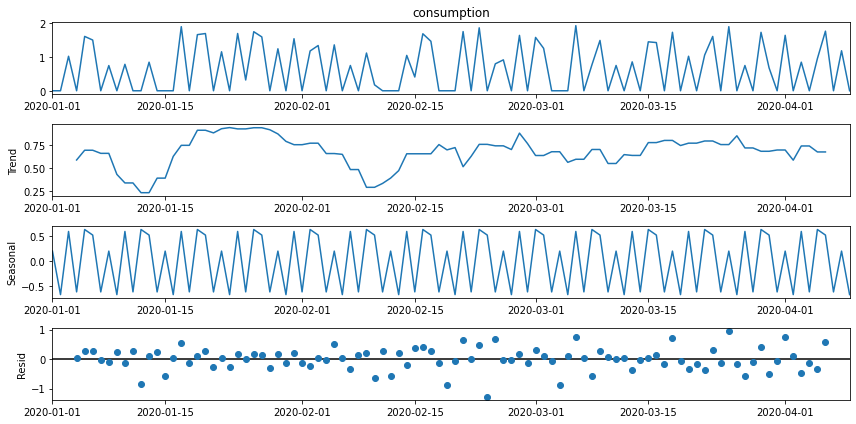

In [170]:
decompose = seasonal_decompose(train[:100], model='additive', period=7)
plt.rc("figure", figsize=(12,6))
decompose.plot()
plt.show()

#### Stationarity Cross Analysis
We can see the relationship in lag value selected in the ADF test and the PACF plot, with significance through around 14 lags. However, in both the ACF and PACF we can see some seasonality in lag significance. Lastly, and most telling, the seasonal decompostion plot shows clear seasonality.

#### What next?
There are two options from here:
1. Remove weekly seasonality
    - LOESS
    - Seasonal differencing
2. Find an optional SARIMA model by grid searching through (p,d,q,P,D,Q) terms.

We'll opt for grid searching SARIMA models to find our ideal model terms (p,d,q,P,D,Q).

### Create Seasonal Arima Model

In [171]:
from pmdarima.model_selection import train_test_split

In [172]:
smodel = pm.auto_arima(train, start_p=0, start_q=0,
                         test='adf',
                         max_p=7, max_q=7, m=7,
                         start_P=0, start_Q = 0, seasonal=True,
                         d=None, D=None, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=753.002, Time=0.09 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=590.837, Time=0.23 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=636.537, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=983.463, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=660.282, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=551.210, Time=0.60 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=474.107, Time=1.32 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=471.145, Time=0.63 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=624.606, Time=0.21 sec
 ARIMA(1,0,0)(1,0,2)[7] intercept   : AIC=474.629, Time=1.32 sec
 ARIMA(1,0,0)(0,0,2)[7] intercept   : AIC=608.053, Time=0.31 sec
 ARIMA(1,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=1.46 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=469.454, Time=0.60 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=665.079, Time=0.07 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=595.606, 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                         y   No. Observations:                  351
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood                -230.727
Date:                   Thu, 26 Nov 2020   AIC                            469.454
Time:                           23:16:27   BIC                            484.898
Sample:                                0   HQIC                           475.601
                                   - 351                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0012      0.002      0.721      0.471      -0.002       0.004
ar.S.L7        0.9983      0.002    476.416      0.000       0.994       1.002
ma.S.L7       -0.9290      0.027    -34.836      0.000      -0.981      -0.877
sigma2         0.2078      0.014     14.786      0.000       0.180       0.235
===================================================================================
Ljung-Box (Q):                       30.58   Jarque-Bera (JB):                10.25
Prob(Q):                              0.86   Prob(JB):                         0.01
Heteroskedasticity (H):               1.07   Skew:                            -0.22
Prob(H) (two-sided):                  0.71   Kurtosis:                         3.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [173]:
# Alternatively, use sarima_forecast module of smart_simulation
smodel = sf.grid_search_sarima(consumption = train,
                               start_p=0,
                               start_q= 0,
                               max_p= 7,
                               max_q= 7,
                               d= None,
                               start_p_seasonal= 0,
                               start_q_seasonal= 0,
                               d_seasonal= None,
                               m = 7)

In [174]:
smodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                         y   No. Observations:                  351
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood                -230.727
Date:                   Thu, 26 Nov 2020   AIC                            469.454
Time:                           23:16:39   BIC                            484.898
Sample:                                0   HQIC                           475.601
                                   - 351                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0012      0.002      0.721      0.471      -0.002       0.004
ar.S.L7        0.9983      0.002    476.416      0.000       0.994       1.002
ma.S.L7       -0.9290      0.027    -34.836      0.000      -0.981      -0.877
sigma2         0.2078      0.014     14.786      0.000       0.180       0.235
===================================================================================
Ljung-Box (Q):                       30.58   Jarque-Bera (JB):                10.25
Prob(Q):                              0.86   Prob(JB):                         0.01
Heteroskedasticity (H):               1.07   Skew:                            -0.22
Prob(H) (two-sided):                  0.71   Kurtosis:                         3.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

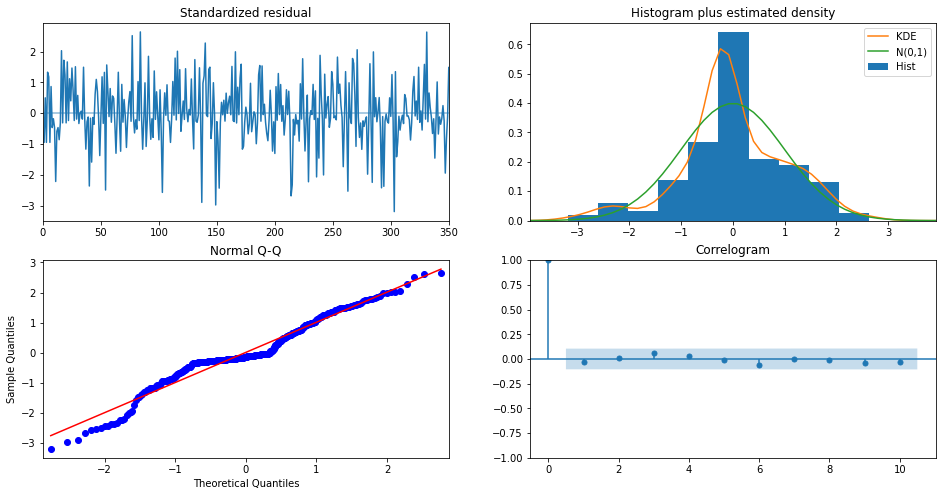

In [175]:
smodel.plot_diagnostics(figsize=(16, 8))
plt.show()

#### Review model residuals
From the Q-Q plot and residuals density, we see some potential room for improvement in the model. We will ingnore that exploration for now.

#### Check an in-place forecast of last 7 days of training set

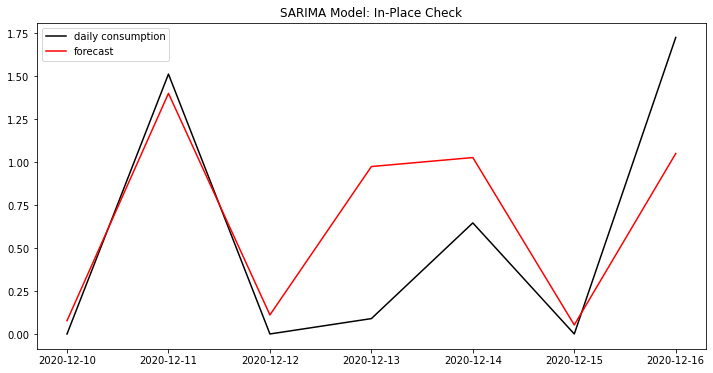

In [192]:
train_length = len(train)
in_place_start = train_length - 7
inplace_forecast = smodel.predict_in_sample(start=in_place_start)
consumption_inplace_forecast = pd.Series(inplace_forecast, index=train.index[-7:])

fig = plt.figure(figsize=(12, 6))
plt.plot(train[-7:], color = 'black', label ='daily consumption')
plt.plot(consumption_inplace_forecast, color = 'red', label ='forecast')
plt.title('SARIMA Model: In-Place Check')
plt.legend()
plt.show()

#### Cross Validate Model

In [201]:
from pmdarima import model_selection

In [ ]:
cv = model_selection.SlidingWindowForecastCV(window_size=100, step=24, h=1)
smodel_cv_scores = model_selection.cross_val_score(model1, train, scoring='smape', cv=cv, verbose=2)
smodel_average_error = np.average(model1_cv_scores)
print("Model Average SMAPE: {}".format(models[better_index]))

### Forecast next 7 days

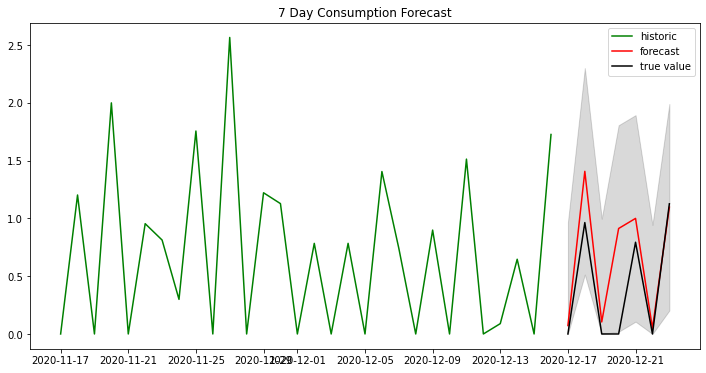

In [197]:
# Forecast
n_periods = 7
forecast, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index = pd.date_range(test.index[0], periods = n_periods, freq='D')

# make series for plotting purpose
forecast_series = pd.Series(forecast, index=index, name='consumption')
lower_series = pd.Series(confint[:, 0], index=index)
lower_series[lower_series < 0] = 0
upper_series = pd.Series(confint[:, 1], index=index)

# Plot
fig = plt.figure(figsize=(12, 6))
plt.plot(train[-30:], color ='green', label='historic')
plt.plot(forecast_series, color='red', label='forecast')
plt.plot(test[:7], color='black', label='true value')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("7 Day Consumption Forecast")
plt.legend()
plt.show()

### Convert Forecast to Theoretical Weight

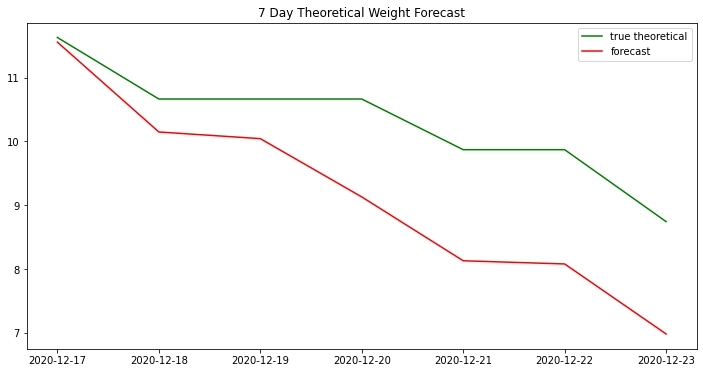

In [200]:
train_weights = eod_weights.loc[train.index]
test_weights = eod_weights.loc[test.index]

start_weight = train_weights[-1]
test_theoretical_weights = de.calculate_theoretical_weights(start_weight=start_weight, consumption_series=test[:7])
predict_theoretical_weights = de.calculate_theoretical_weights(start_weight=start_weight, consumption_series=forecast_series)


# Plot
fig = plt.figure(figsize=(12, 6))
plt.plot(test_theoretical_weights, color ='green', label='true theoretical')
plt.plot(predict_theoretical_weights, color='red', label='forecast')

plt.title("7 Day Theoretical Weight Forecast")
plt.legend()
plt.show()

### Calculate Remaining Days of Consumption

In [202]:
copy_model = smodel.copy()

type(copy_model)

AttributeError: 'ARIMA' object has no attribute 'copy'

### Score Model
1. just score the consumption regression
2. acknowledge that this score is best for DS to relate, business would prefer to see scores around days remaining

# Modeling framework
- create a new model for every scale once a month
- update every day with new data

https://stackoverflow.com/questions/56335992/how-to-perform-multi-step-out-of-time-forecast-which-does-not-involve-refitting#answer-58360100:~:text=You,-are
"if you want to do online forecasting using new data you will need to estimate the parameters over and over again which is computationally inefficient"

https://towardsdatascience.com/3-facts-about-time-series-forecasting-that-surprise-experienced-machine-learning-practitioners-69c18ee89387
- "You need to retrain your model every time you want to generate a new prediction"